# Import library

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check pytorch version
torch.__version__

'2.5.1+cu121'

# Data (preparing and loading)

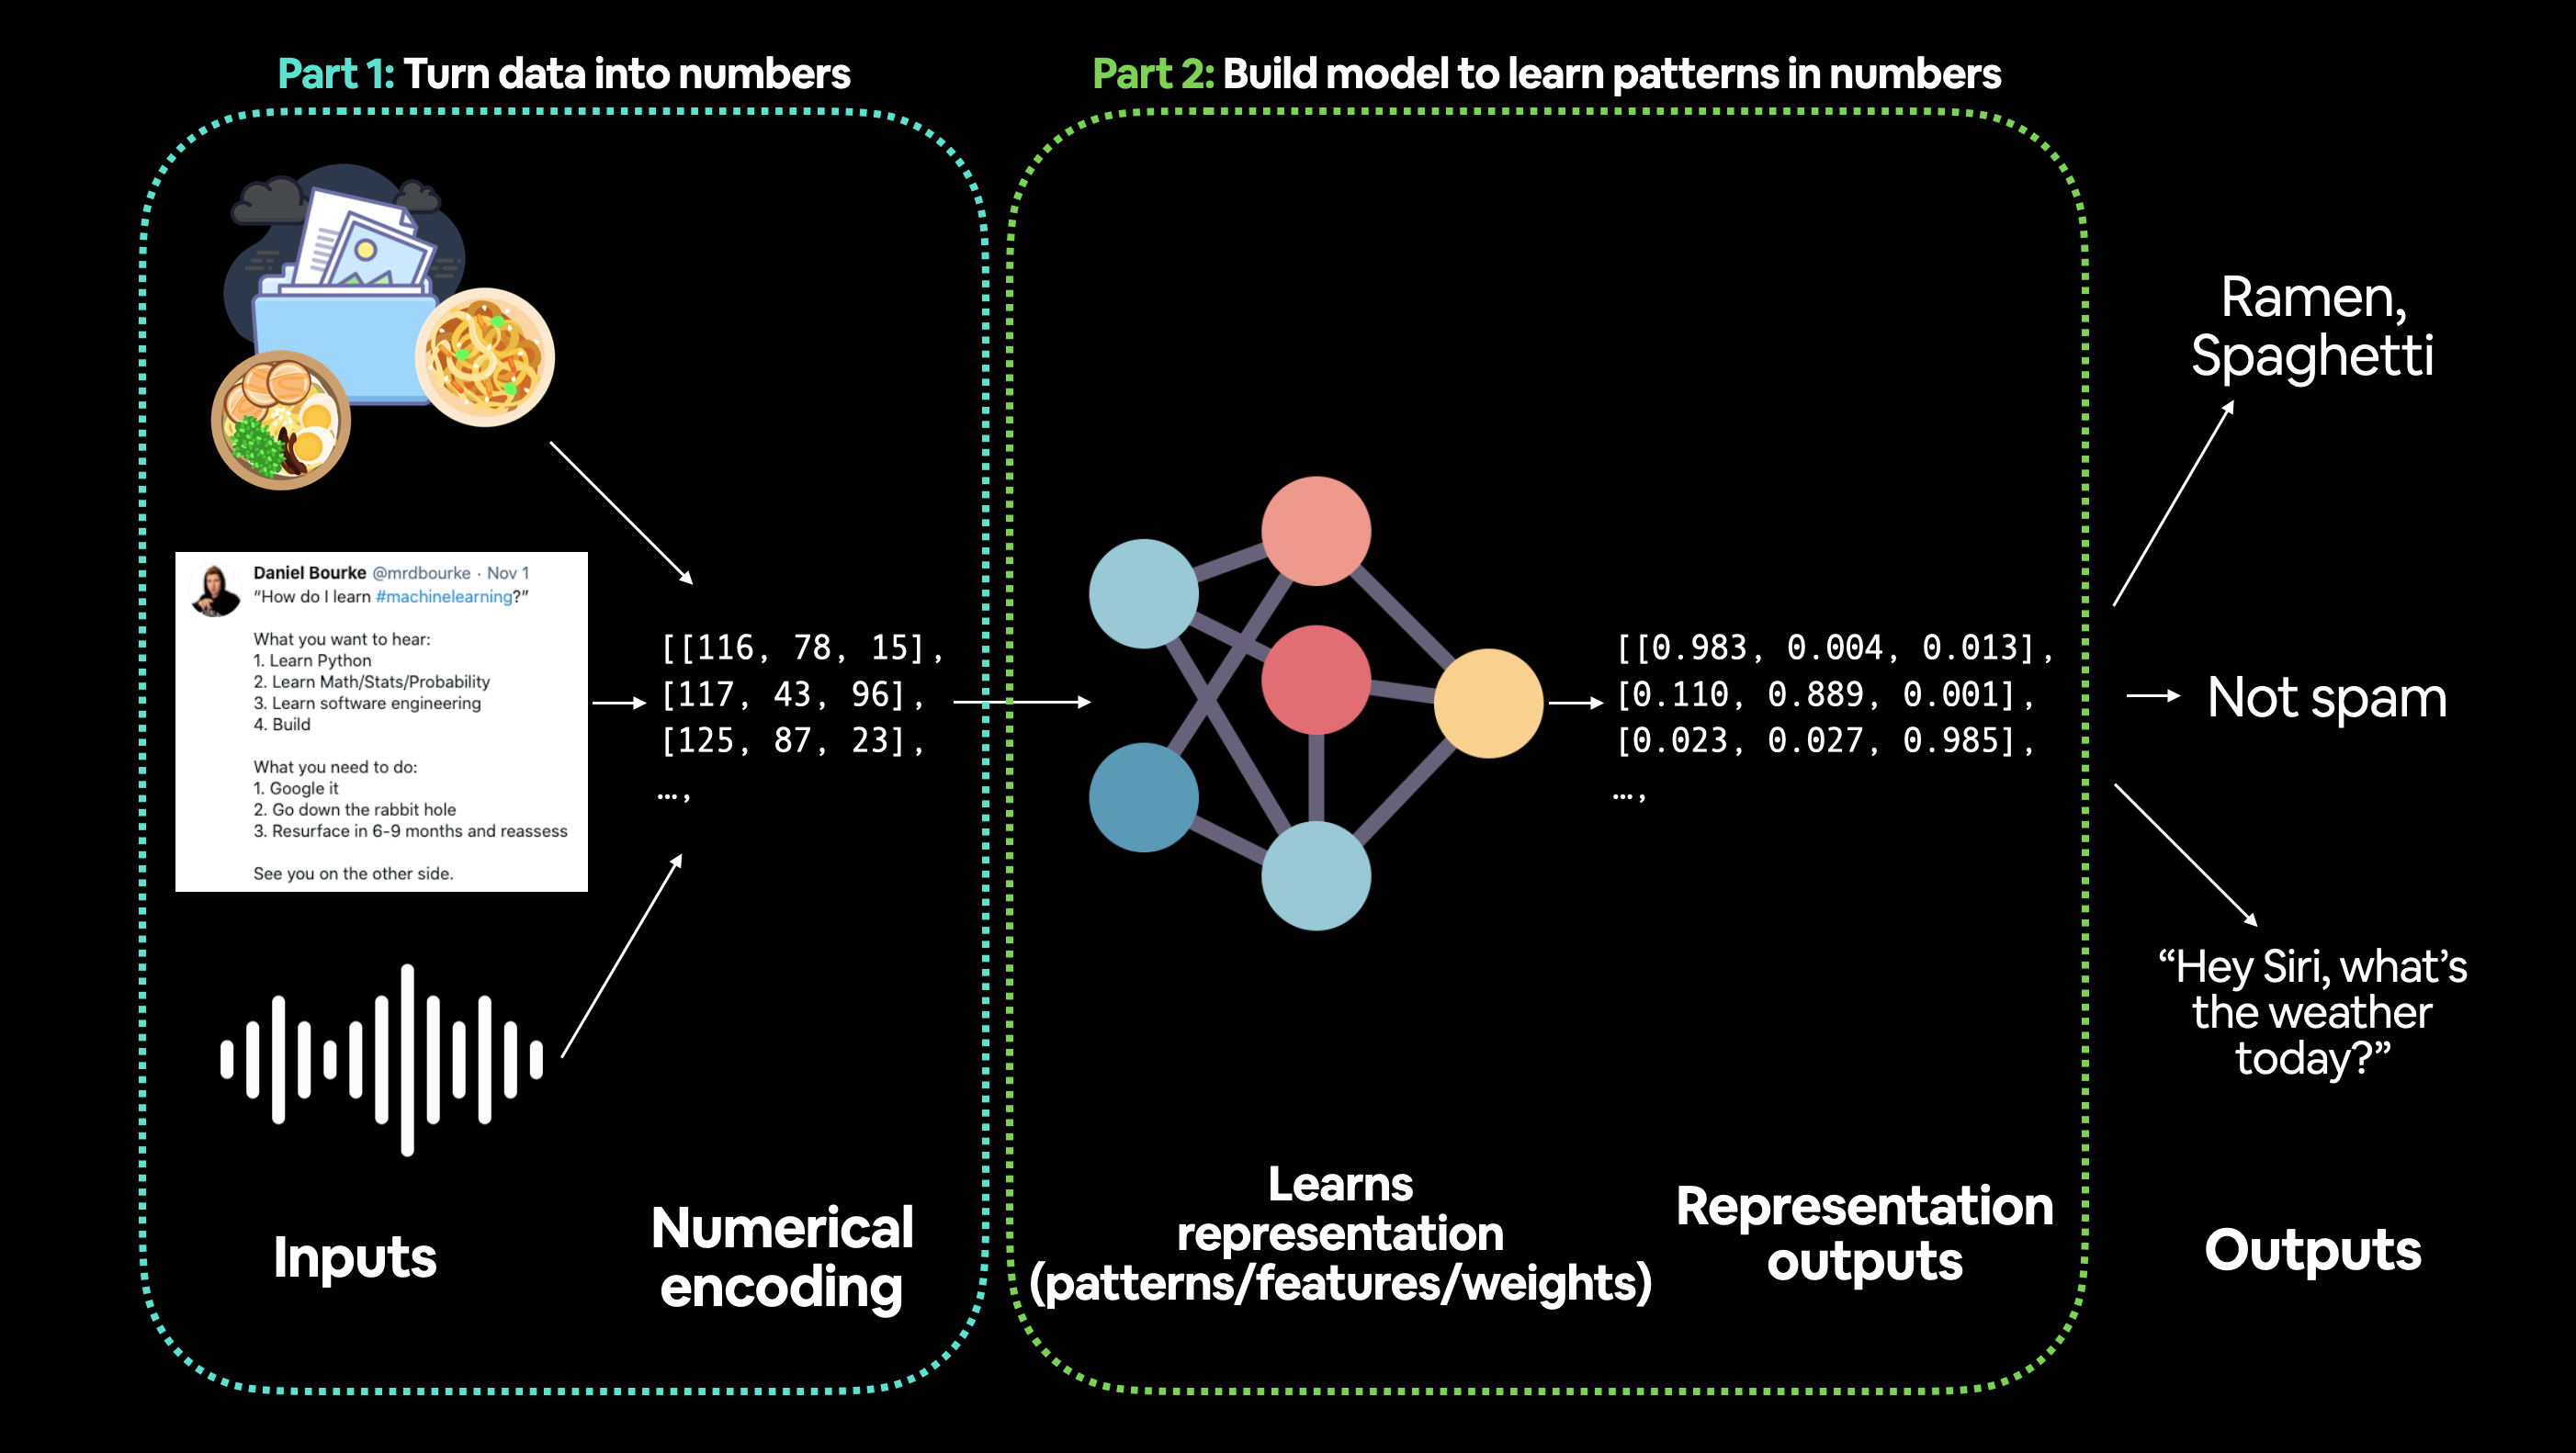

Machine learning is a game of two parts:

1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

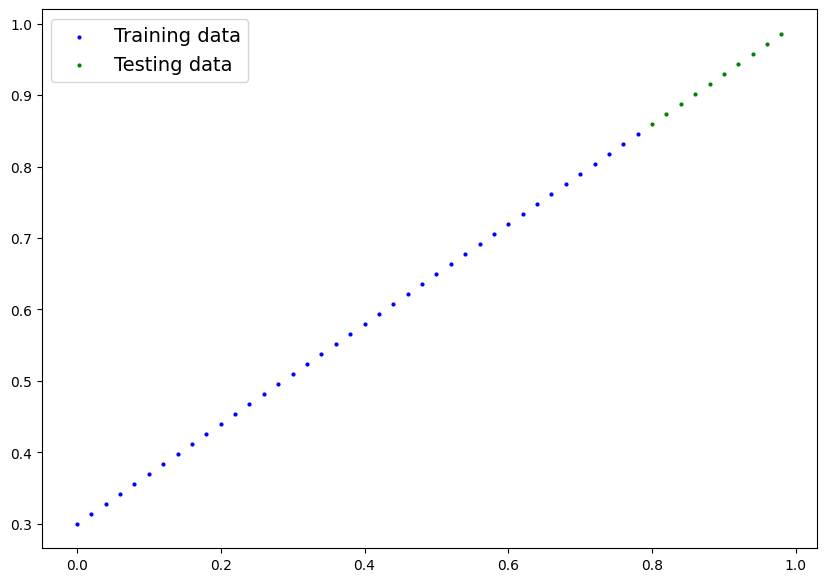

In [ ]:
plot_predictions();

# Build model

Giải thích về `torch.nn.parameter.Parameter`
- `torch.nn.parameter.Parameter` là một lớp con của torch.Tensor, được thiết kế đặc biệt để biểu diễn các tham số (parameters) trong một mô hình `torch.nn.Module`.

1. Đặc điểm chính của Parameter
- Khi một Parameter được gán làm thuộc tính của một Module, nó sẽ tự động được thêm vào danh sách các tham số của Module.
  - Ví dụ: Nó xuất hiện trong `model.parameters()` hoặc `model.named_parameters()`.
- Khác biệt với Tensor thông thường:
  - Nếu bạn gán một `torch.Tensor` thông thường vào một Module, nó sẽ không tự động được coi là tham số của Module. Điều này cho phép bạn quản lý rõ ràng giữa tham số huấn luyện và các trạng thái tạm thời (temporary states).
2. Tại sao cần Parameter?
- Trong các mô hình học sâu, cần phân biệt giữa:
  1. Tham số huấn luyện (trainable parameters):
    - Là các trọng số (weights) hoặc độ chệch (biases) mà mô hình cần tối ưu hóa trong quá trình huấn luyện.
  2. Trạng thái tạm thời (temporary states):
  - Là các giá trị được tính toán hoặc lưu trữ tạm thời trong quá trình xử lý, ví dụ: trạng thái ẩn (hidden state) của mạng RNN.
- Nếu không có Parameter, tất cả các tensor được gán vào mô hình sẽ được đăng ký là tham số, dẫn đến khó kiểm soát và rủi ro.
3. Cú pháp
- Ex: `torch.nn.parameter.Parameter(data=None, requires_grad=True)`
- Tham số
  - data (Tensor):
    - Giá trị khởi tạo cho Parameter.
    - Ví dụ: Một tensor chứa trọng số hoặc độ chệch ban đầu.
  - requires_grad (bool, mặc định là True):
    - Quy định xem Parameter có yêu cầu tính gradient hay không.
    - Nếu True, gradient sẽ được tính và tham số này sẽ được tối ưu hóa trong quá trình backpropagation.

* Lưu ý đặc biệt
  - Context `torch.no_grad()` không ảnh hưởng đến requires_grad khi tạo Parameter.
    - Dù bạn ở trong khối `torch.no_grad()`, Parameter mặc định vẫn sẽ có `requires_grad=True`.

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                    dtype=torch.float), # <- PyTorch loves float32 by default
                                    requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                  dtype=torch.float), # <- PyTorch loves float32 by default
                                  requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## PyTorch model building essentials

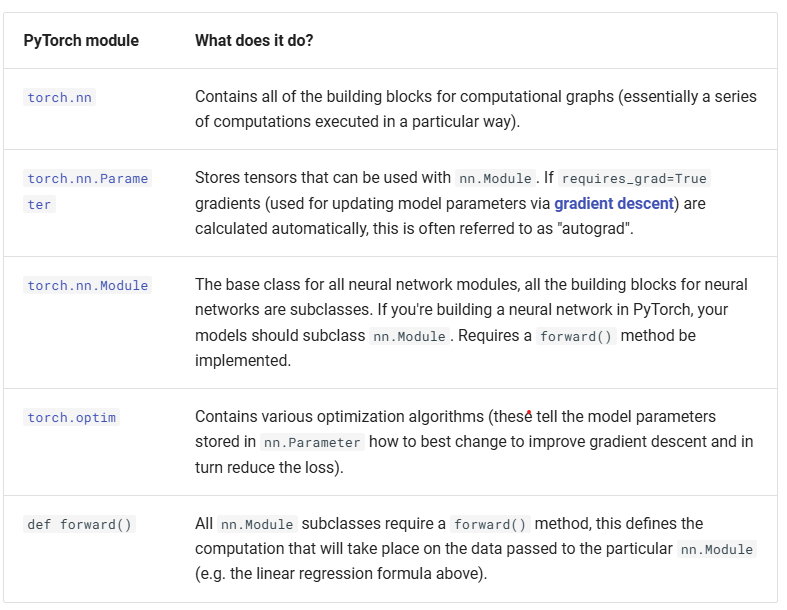

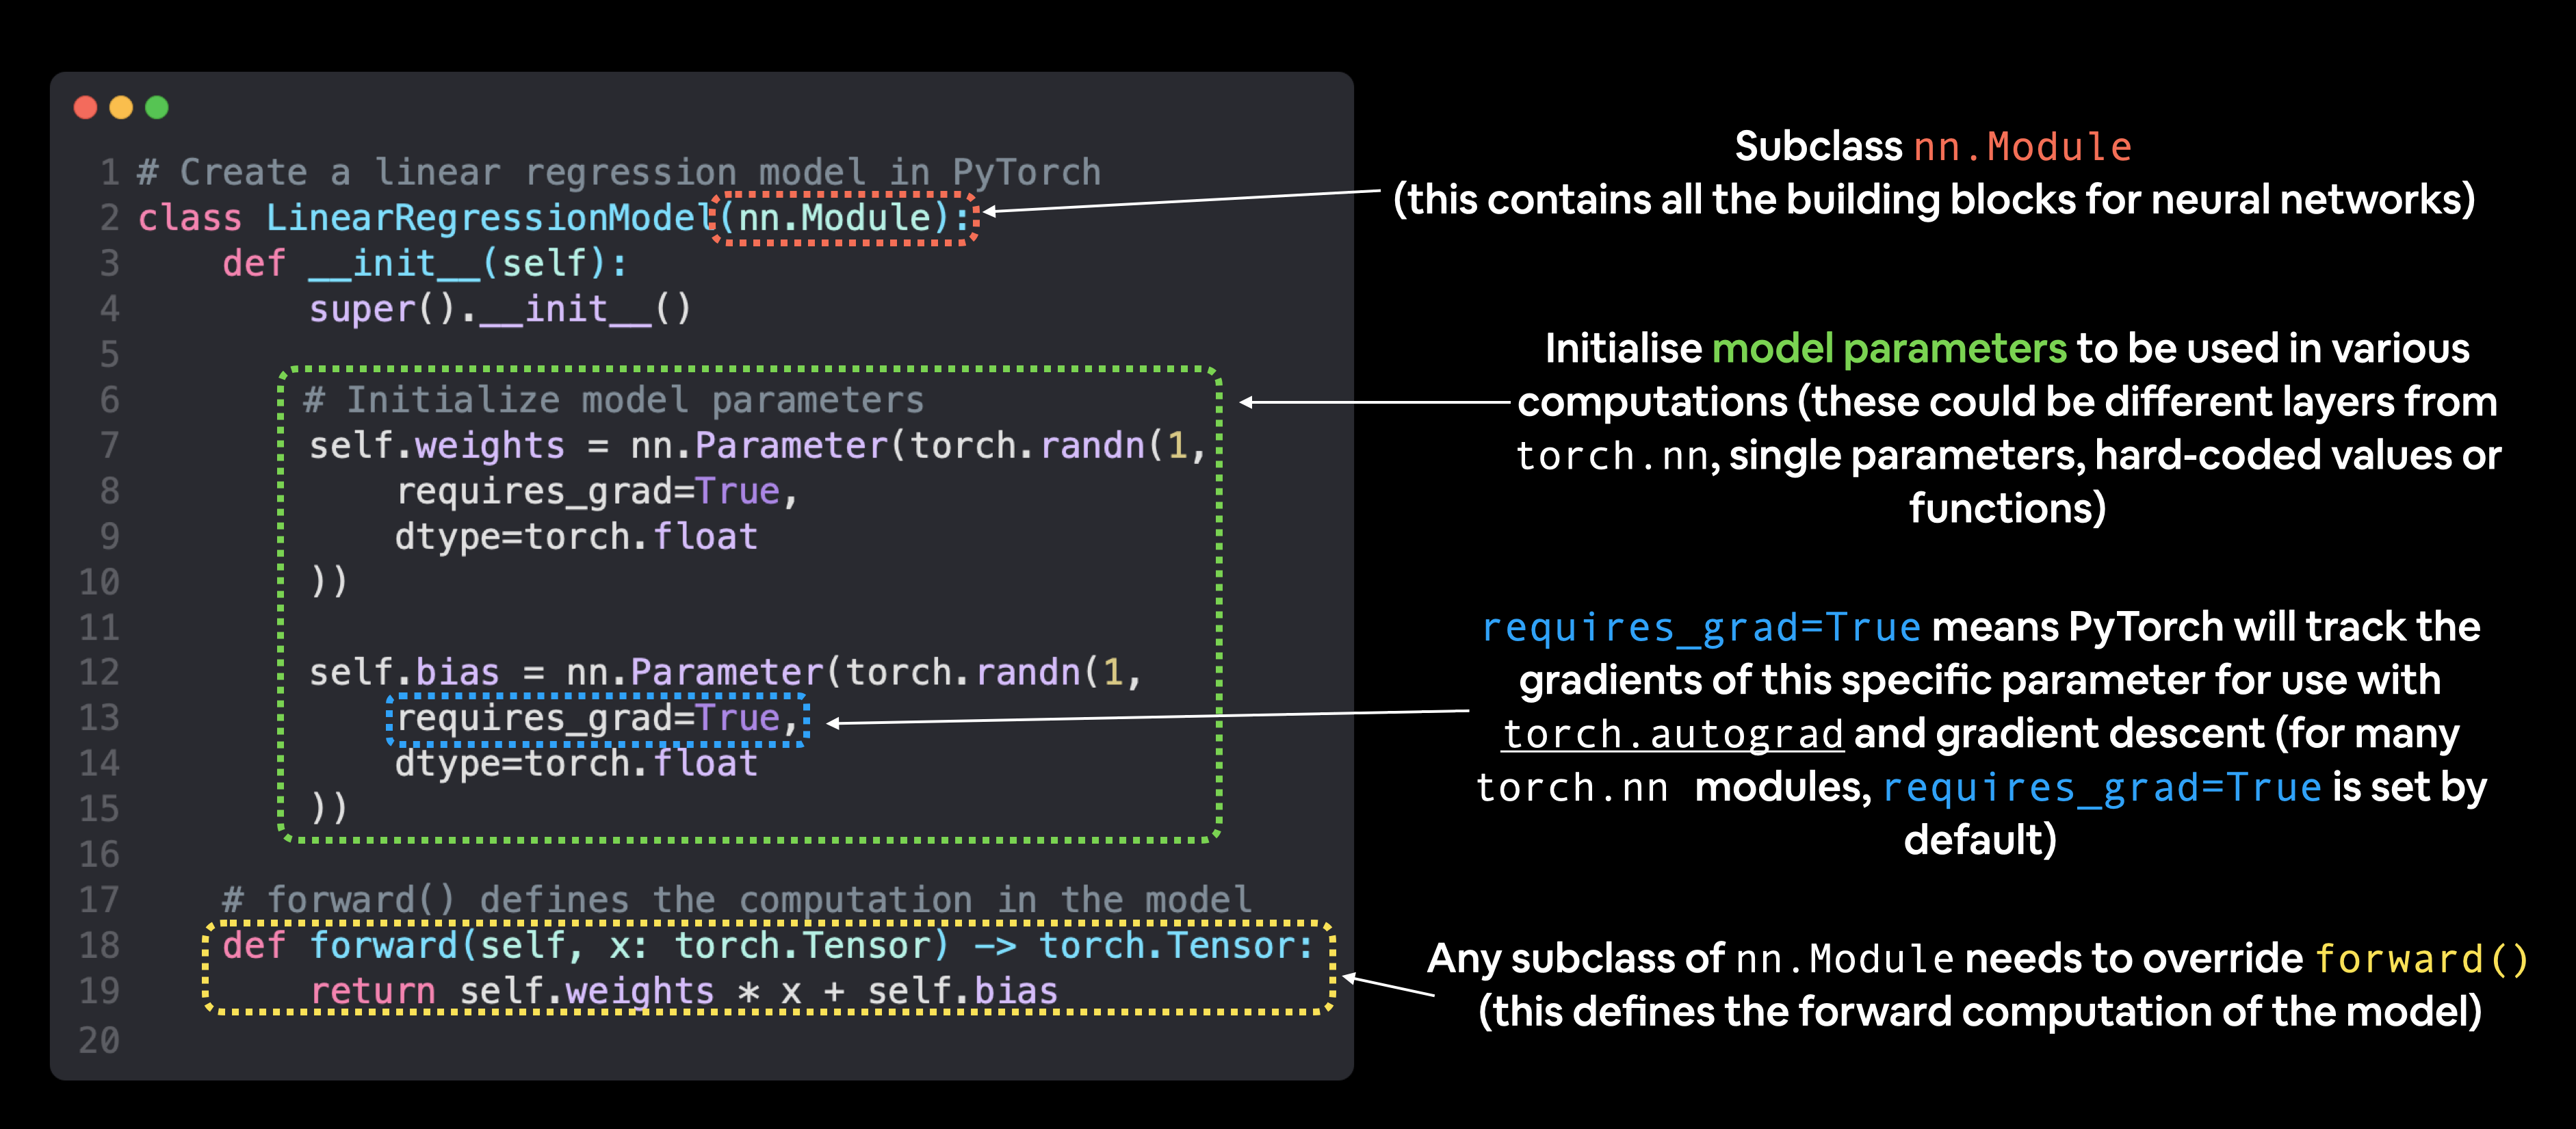

## Checking the contents of a PyTorch model

In [ ]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode()`

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

- Trong PyTorch, `torch.inference_mode()` và `torch.no_grad()` là hai chế độ được dùng để tối ưu hóa việc dự đoán (inference) với mô hình học sâu.
      `torch.inference_mode()`
- Ý nghĩa: Được sử dụng khi bạn chỉ thực hiện suy luận (inference) mà không cần tính toán gradient hoặc cập nhật tham số của mô hình.
- Lợi ích:
  - Tắt gradient tracking: Việc theo dõi gradient chỉ cần thiết khi huấn luyện (training). Trong inference, việc này không cần thiết và tiêu tốn tài nguyên.
  - Tăng hiệu suất: Tắt các hoạt động không cần thiết như gradient tracking giúp forward-pass (lượt truyền dữ liệu qua forward() method) nhanh hơn.
  - Mới hơn và tối ưu hơn: Ra mắt sau `torch.no_grad()` và được tối ưu để sử dụng trong inference.

- Inference (hay suy luận) trong học sâu là quá trình sử dụng một mô hình đã được huấn luyện để dự đoán hoặc tính toán kết quả từ dữ liệu đầu vào mới. Quá trình suy luận hiểu đơn giản là quá trình sử dụng model đã train trên tập test để dự đoán kết quả.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


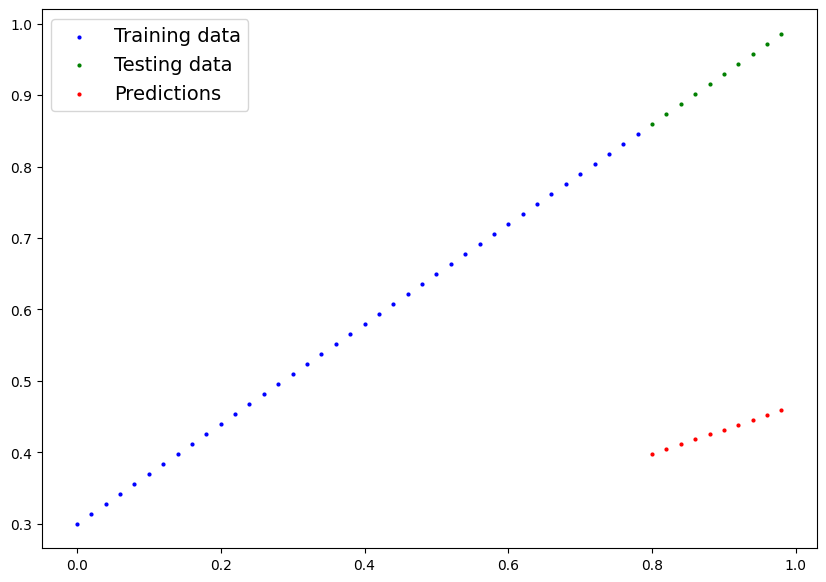

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

# Train model

- Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).
- To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.
- We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?
- Much of the time you won't know what the ideal parameters are for a model.
- Instead, it's much more fun to write code to see if the model can try and figure them out itself.

## Creating a loss function and optimizer in PyTorch

- For our model to update its parameters on its own, we'll need to add a few more things to our recipe.
- And that's a loss function as well as an optimizer.
- The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

We'll use SGD, `torch.optim.SGD(params, lr)` where:
- Trong học sâu, SGD (Stochastic Gradient Descent) là một thuật toán tối ưu hóa phổ biến được sử dụng để cập nhật các tham số của mô hình (ví dụ: trọng số và bias) trong quá trình huấn luyện.
**Giải thích chi tiết về các thành phần:**
1. `torch.optim.SGD(params, lr)`:
- params:
  - Là danh sách hoặc iterator chứa các tham số của mô hình cần tối ưu hóa, ví dụ: trọng số (weights) và hệ số bias của các lớp trong mô hình.
  - Thường được truyền vào bằng cách gọi `model.parameters()` trong PyTorch.
- lr (Learning Rate):
  - Tốc độ học (learning rate) là một siêu tham số điều chỉnh kích thước bước mà thuật toán sử dụng để cập nhật tham số trong mỗi vòng lặp.
  - Giá trị lr quyết định mức độ thay đổi của các tham số trong quá trình tối ưu hóa.
2. Learning Rate (lr) và vai trò:
- Learning rate lớn:
  - Tối ưu nhanh hơn do mỗi bước cập nhật trọng số lớn.
  - Nhưng nếu quá lớn, mô hình có thể bỏ qua điểm tối ưu và dẫn đến việc hội tụ kém (diverge).
- Learning rate nhỏ:
  - Mô hình cập nhật từng bước nhỏ hơn, cho phép hội tụ ổn định hơn.
  - Nhưng nếu quá nhỏ, quá trình tối ưu hóa sẽ mất nhiều thời gian.
- Giá trị phổ biến: 0.01, 0.001, 0.0001. Tuy nhiên, giá trị này cần thử nghiệm và điều chỉnh phù hợp với từng bài toán.
3. Learning Rate Scheduling:
- Trong quá trình huấn luyện, việc giữ nguyên learning rate có thể không tối ưu.
- Learning rate scheduling là kỹ thuật thay đổi learning rate trong các giai đoạn khác nhau:
  - Lớn ban đầu để học nhanh các đặc trưng thô.
  - Nhỏ dần để tinh chỉnh các tham số và đạt độ chính xác cao hơn.
- PyTorch cung cấp các công cụ như `torch.optim.lr_scheduler` để điều chỉnh learning rate tự động.





In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Tạo một mô hình đơn giản
# model = nn.Linear(10, 1)  # Mô hình Linear với 10 input features và 1 output
# loss_fn = nn.MSELoss()    # Hàm mất mát Mean Squared Error (MSE)

# # Khởi tạo SGD Optimizer với learning rate 0.01
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Dữ liệu giả lập
# X = torch.randn(5, 10)  # Batch size = 5, input features = 10
# y = torch.randn(5, 1)   # Output tương ứng

# # Huấn luyện mô hình
# for epoch in range(100):
#     # Forward pass
#     predictions = model(X)
#     loss = loss_fn(predictions, y)

#     # Backward pass và cập nhật tham số
#     optimizer.zero_grad()  # Đặt lại gradient
#     loss.backward()        # Tính gradient
#     optimizer.step()       # Cập nhật tham số dựa trên gradient và learning rate

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

## PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

1. Forward Pass:
  - Mô tả: Đây là bước đầu tiên trong quá trình huấn luyện, trong đó mô hình sẽ nhận dữ liệu đầu vào và tính toán các giá trị dự đoán bằng cách đi qua hàm `forward()`.
  - Mục tiêu: Dự đoán đầu ra (output) của mô hình dựa trên dữ liệu huấn luyện (training data).
  `y_pred = model(x_train)  # Mô hình tính toán dự đoán từ dữ liệu đầu vào`
2. Calculate the Loss:
  - Mô tả: Sau khi mô hình dự đoán (forward pass), bước tiếp theo là tính toán loss (mất mát). Loss là chỉ số đánh giá mức độ sai lệch giữa dự đoán của mô hình (y_pred) và giá trị thực tế (ground truth, y_train).
  - Mục tiêu: Đo lường độ sai lệch giữa dự đoán và giá trị thực tế, từ đó giúp tối ưu hóa mô hình trong các bước tiếp theo.

  `loss = loss_fn(y_pred, y_train) #Tính giá trị mất mát giữa dự đoán và giá trị thực tế`
3. Zero Gradients:
  - Mô tả: PyTorch tính toán gradients (đạo hàm) cho các tham số của mô hình trong mỗi lần gọi `loss.backward()`. Tuy nhiên, gradients sẽ được tích lũy (cộng dồn) trong các lần tính toán liên tiếp. Để tránh làm sai lệch quá trình huấn luyện, chúng ta cần đặt lại gradients về 0 trước mỗi bước huấn luyện.
  - Mục tiêu: Đảm bảo rằng gradients được tính lại từ đầu cho mỗi bước huấn luyện mới.
        `optimizer.zero_grad()  # Đặt lại gradients về 0`
4. Perform Backpropagation:
  - Mô tả: Sau khi tính toán loss, bước tiếp theo là backpropagation. Bằng cách gọi `loss.backward()`, PyTorch tính toán gradient của loss đối với tất cả các tham số có `requires_grad=True` (tức là các tham số có thể học được, ví dụ: trọng số và bias của mô hình). Quá trình này gọi là lan truyền ngược.
  - Mục tiêu: Tính toán gradients của tham số mô hình để biết được hướng và độ lớn cần điều chỉnh trong bước tiếp theo.
`loss.backward()  # Tính toán gradient của loss theo các tham số`
5. Update the Optimizer (Gradient Descent):
  - Mô tả: Sau khi tính toán gradients, bước cuối cùng là cập nhật các tham số của mô hình (ví dụ: trọng số và bias) để giảm loss. Việc cập nhật tham số này dựa trên gradient đã tính toán và learning rate đã định. Quá trình này là gradient descent (hạ dốc theo gradient).
  - Mục tiêu: Điều chỉnh các tham số của mô hình để giảm dần loss trong các lần huấn luyện tiếp theo.
`optimizer.step()  # Cập nhật tham số của mô hình dựa trên gradients`
6. Tóm tắt lại quy trình huấn luyện (training loop):
  1. Forward pass: Mô hình tính toán đầu ra từ dữ liệu đầu vào.
  2. Calculate loss: Tính toán mức độ sai lệch giữa dự đoán và giá trị thực tế (ground truth).
  3. Zero gradients: Đặt lại gradient về 0 để chuẩn bị tính toán mới cho mỗi bước.
  4. Backpropagation: Tính toán gradients của loss đối với các tham số của mô hình.
  5. Update optimizer: Cập nhật các tham số mô hình theo gradient tính được, giúp giảm thiểu loss

In [ ]:
# # Mô hình đơn giản
# model = nn.Linear(10, 1)
# loss_fn = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Dữ liệu giả lập
# X = torch.randn(5, 10)  # 5 mẫu, 10 đặc trưng
# y = torch.randn(5, 1)   # Output tương ứng

# # Huấn luyện trong 100 epoch
# for epoch in range(100):
#     # Step 1: Forward pass
#     y_pred = model(X)

#     # Step 2: Calculate loss
#     loss = loss_fn(y_pred, y)

#     # Step 3: Zero gradients
#     optimizer.zero_grad()

#     # Step 4: Backpropagation
#     loss.backward()

#     # Step 5: Update optimizer (gradient descent)
#     optimizer.step()

#     # In loss
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

## PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # Lan truyền ngược (Backpropagation) là quá trình tính toán gradient của hàm mất mát (loss) đối với tất cả các tham số của mô hình
    # (trọng số và bias) bằng cách áp dụng Định lý chuỗi (Chain Rule).
    # loss.backward() thực hiện toàn bộ công việc này một cách tự động trong PyTorch, nhờ vào Autograd (tự động tính gradient).

    # 5. Progress the optimizer
    optimizer.step()
    # Sau khi gradient được tính toán thông qua loss.backward(), optimizer.step() sử dụng các gradient này để cập nhật tham số của mô hình (trọng số và bias) nhằm giảm hàm mất mát.
    # Các thuật toán Optimizer:
    # SGD (Stochastic Gradient Descent):
    # Cập nhật trực tiếp dựa trên gradient và learning rate.
    # Adam (Adaptive Moment Estimation):
    # Kết hợp tốc độ học thích ứng và động lượng, giúp quá trình hội tụ nhanh hơn.

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


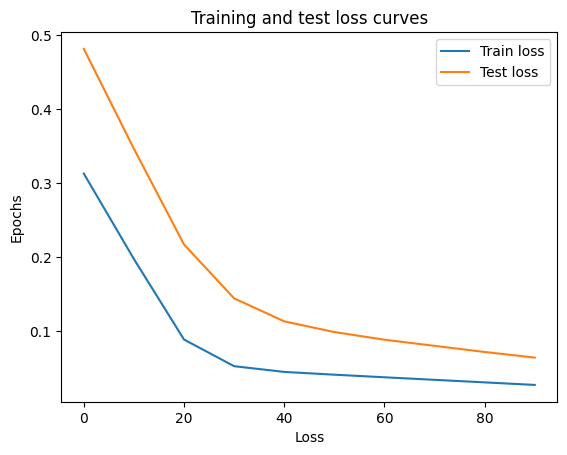

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.legend()

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Making predictions with a trained PyTorch model (inference)

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

- Trong PyTorch, `.eval()` là một phương thức của lớp nn.Module được sử dụng để đặt mô hình vào chế độ đánh giá (evaluation mode). Điều này rất quan trọng khi bạn muốn sử dụng mô hình để thực hiện suy luận (inference) sau khi đã được huấn luyện.

- **Chế độ `.eval()` làm gì?**
1. Tắt Dropout:
  - Dropout là một cơ chế được sử dụng trong quá trình huấn luyện để tránh overfitting bằng cách ngẫu nhiên "tắt" một số neurons.
  - Trong chế độ `.eval()`, Dropout sẽ bị tắt để tất cả các neurons đều hoạt động.
2. Tắt Batch Normalization (Running Statistics):
  - Batch Normalization (BatchNorm) tính toán các thông số thống kê (mean, variance) của batch dữ liệu trong quá trình huấn luyện.
  - Khi vào chế độ `.eval()`, BatchNorm sẽ sử dụng các giá trị thống kê toàn cục (được cập nhật trong quá trình huấn luyện) thay vì giá trị thống kê của batch hiện tại.
3. Không ảnh hưởng đến các tham số khác:
  - `.eval()` không làm thay đổi các tham số của mô hình, chỉ ảnh hưởng đến cách các lớp như Dropout hoặc BatchNorm hoạt động.

- **Khi nào cần sử dụng `.eval()`?**
  - Thực hiện suy luận (inference): Đánh giá mô hình trên tập kiểm tra hoặc sử dụng mô hình đã huấn luyện để dự đoán.
  - Đảm bảo kết quả chính xác vì mô hình cần hoạt động đúng với trạng thái sử dụng.

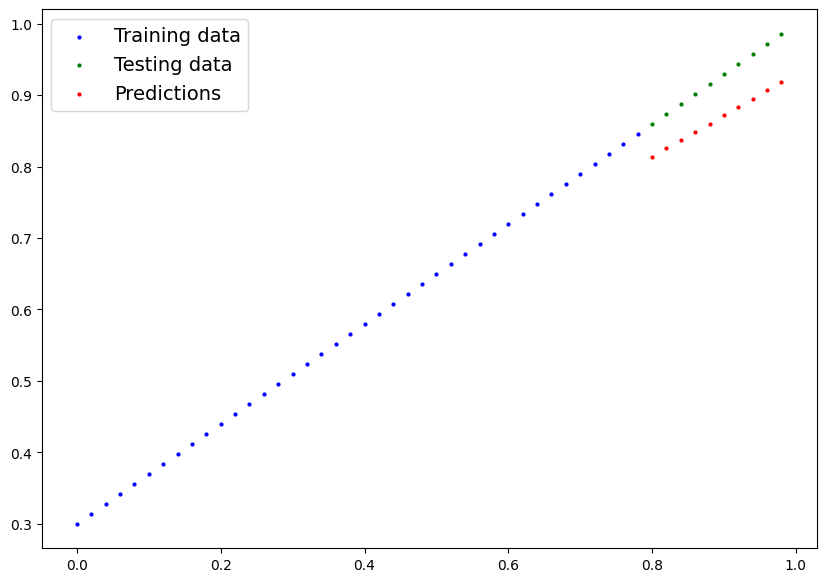

In [ ]:
plot_predictions(predictions=y_preds)

# Saving and loading a PyTorch model

| PyTorch method | What does it do? |
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. |


**1. `torch.save`**
- Chức năng: Lưu một đối tượng đã được tuần tự hóa (serialized object) vào ổ đĩa bằng cách sử dụng tiện ích pickle của Python.
- Sử dụng:
  - Dùng để lưu:
    - Mô hình đã huấn luyện (`model.state_dict()`).
    - Các tensors hoặc cấu trúc dữ liệu khác (như dictionaries chứa hyperparameters, epochs...).

In [ ]:
model = LinearRegressionModel()
torch.save(model.state_dict(), "model.pth") # Lưu trạng thái (weights) của model

- Lưu ý: `torch.save` chỉ lưu đối tượng, không quan tâm đến cấu trúc của model. Khi load, bạn cần phải biết chính xác cách khởi tạo lại mô hình.

**2. `torch.load`**
- Chức năng: Dùng để tải (deserialize) một đối tượng đã được lưu trước đó (thường là `state_dict`, mô hình, tensor, hoặc dữ liệu khác) vào bộ nhớ.
- Điểm đặc biệt:
  - Chỉ tải dữ liệu vào bộ nhớ, không tự động gán nó vào một mô hình cụ thể.
  - Kết quả là một Python object (ví dụ: dictionary chứa parameters).
- Tính năng bổ sung: Có thể chọn thiết bị (CPU, GPU) để tải đối tượng.
- Sử dụng:
  - Thường dùng để tải lại các mô hình đã lưu (`state_dict()`).

In [ ]:
model_weights = torch.load("model.pth", map_location=torch.device('cpu')) # Tải weights về CPU

<ipython-input-65-f99d3ba25429>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load("model.pth", map_location=torch.device('cpu')) # Tải weights về C

- Lưu ý:
  - Nếu mô hình được lưu trên GPU nhưng bạn chỉ có CPU, cần thêm map_location để chuyển đổi thiết bị.

**3. `torch.nn.Module.load_state_dict`**
- Chức năng: Dùng để nạp các tham số (weights, biases) đã lưu trong một `state_dict` vào một mô hình PyTorch (`nn.Module`).
- Điểm đặc biệt:
  - Cần có một mô hình đã được định nghĩa (với kiến trúc tương ứng) trước khi sử dụng.
  - Tham số trong state_dict sẽ được ánh xạ vào mô hình đã khởi tạo.
- Sử dụng:
  - Khi tải weights đã lưu, cần khớp đúng kiến trúc của mô hình.
  - Thường kết hợp với `torch.load()`.

In [ ]:
model.load_state_dict(torch.load("model.pth"))
model.eval()

<ipython-input-66-e5679bdf4a69>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


LinearRegressionModel()

- Lưu ý:
  - Kiến trúc mô hình (class định nghĩa) cần khớp với file weights được lưu.

## Saving a PyTorch model's `state_dict()`

- The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.
- Let's see how we can do that in a few steps:
  1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
  2. We'll create a file path to save the model to.
  3. We'll call `torch.save(obj, f)` where obj is the target model's `state_dict()` and `f` is the filename of where to save the model.
- Note: It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Nov 18 08:20 models/01_pytorch_workflow_model_0.pth


## Loading a saved PyTorch model's `state_dict()`

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-69-d9b88826cbb6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Data

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

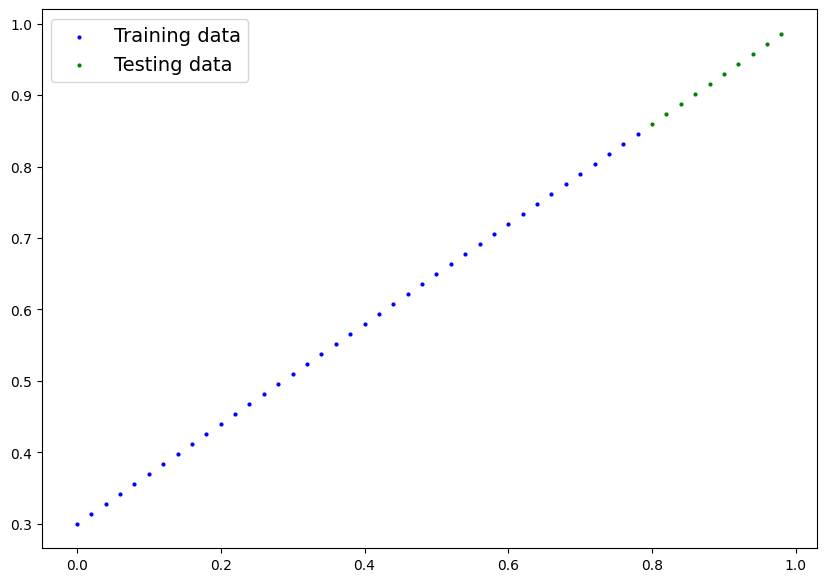

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## Building a PyTorch linear model

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     # Use nn.Linear() for creating the model parameter
     self.linear_layer = nn.Linear(in_features=1, out_features=1)

  # Define the forward computation (input data x flows through nn.Linear())
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if it's available. otherwise it'll default to CPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## Training

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train() # train mode is on by default after construction

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval() # put the model in evaluation mode for testing (inference)
  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [ ]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

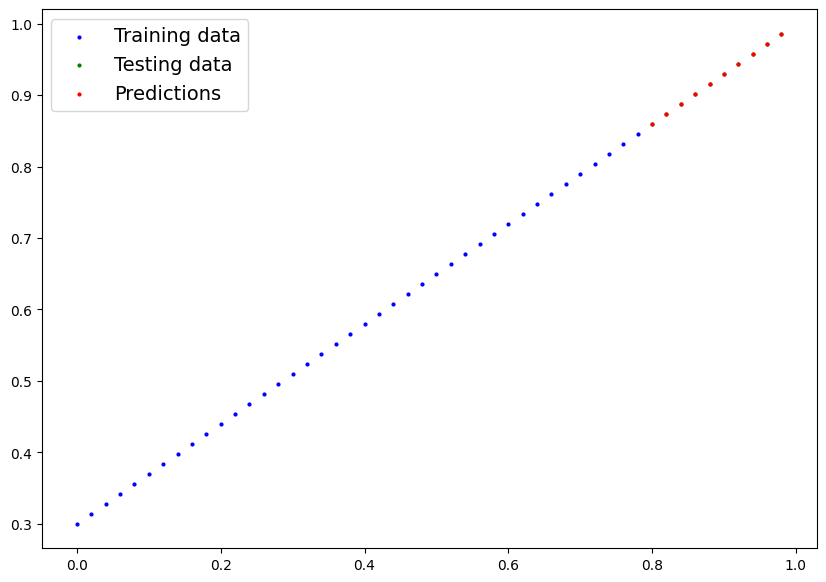

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

## Saving and loading a model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


<ipython-input-94-c4e3cba863db>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])